# KDE Sampling

police.uk data has high (perturbed?) spatial resolution but very poor temporal (month of occurrence) and only broad categorical resolution:

- Anti-social behaviour
- Other theft
- Violence and sexual offences
- Bicycle theft
- Criminal damage and arson
- Public order
- Robbery
- Shoplifting
- Vehicle crime
- Drugs
- Possession of weapons
- Theft from the person
- Burglary
- Other crime

This notebook creates a Kernel Density Estimate (KDE) over an entire force area, for one of the above crime categories, using 3 years data.

Synthetic crimes can then be sampled from this spatial distribution


In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from functools import partial

import geopandas as gpd
import numpy as np
from itrx import Itr
from scipy.stats import gaussian_kde

from spatial import get_census_boundaries, get_force_boundary
from utils import CATEGORIES, Month, load_crime_data, monthgen

In [17]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]
LATEST_DATE = Month(2025, 5)
filter = {"Crime type": CATEGORY}
rng = np.random.default_rng(19937)

crime_data = load_crime_data(FORCE, Itr(monthgen(LATEST_DATE, backwards=True)).take(36), filters=filter)
force_boundary = get_force_boundary(FORCE)
crime_data = crime_data.sjoin(force_boundary)
crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry,index_right,PFA23CD,PFA23NM
Crime ID,,,,,,,,,,,
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411838.68 447615.131),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Heather Court,E01010692,Bradford 001D,Anti-social behaviour,POINT (411526.994 447273.002),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Undercliffe Rise,E01010691,Bradford 002A,Anti-social behaviour,POINT (413203.97 446959.981),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Hangingstone Road,E01010691,Bradford 002A,Anti-social behaviour,POINT (413060.022 446952.013),9,E23000010,West Yorkshire
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Sports/Recreation Area,E01010694,Bradford 002C,Anti-social behaviour,POINT (412011.181 448468.845),9,E23000010,West Yorkshire
...,...,...,...,...,...,...,...,...,...,...,...
None,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Mill Close,E01011864,Wakefield 045A,Anti-social behaviour,POINT (444241.994 410485.05),9,E23000010,West Yorkshire
None,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Supermarket,E01011868,Wakefield 045C,Anti-social behaviour,POINT (445039.991 410940.983),9,E23000010,West Yorkshire
None,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Supermarket,E01011868,Wakefield 045C,Anti-social behaviour,POINT (445039.991 410940.983),9,E23000010,West Yorkshire


In [18]:
lsoa_boundaries = get_census_boundaries("LSOA21", resolution="FE", overlapping=force_boundary)
lsoa_boundaries

,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,geometry
LSOA21CD,,,,,,,
E01010568,Bradford 016A,None,416258,438952,53.8466,-1.75438,"POLYGON ((416422.17 439366.289, 416417.848 439..."
E01010569,Bradford 016B,None,414693,438453,53.8421,-1.77819,"POLYGON ((415369.043 439212.461, 415368.435 43..."
E01010570,Bradford 018A,None,413992,438990,53.8470,-1.78881,"POLYGON ((414005.26 439378.989, 414146.534 439..."
E01010571,Bradford 016C,None,415223,438398,53.8416,-1.77013,"POLYGON ((415768.621 438654.729, 415766.728 43..."
E01010572,Bradford 016D,None,415428,438857,53.8457,-1.76700,"POLYGON ((415616.807 439194.596, 415622.818 43..."
...,...,...,...,...,...,...,...
E01035050,Leeds 105G,None,430214,426790,53.7366,-1.54345,"POLYGON ((430986.896 427756.226, 430982.739 42..."
E01035051,Leeds 105H,None,431335,427174,53.7400,-1.52641,"POLYGON ((431044.305 427760.241, 431050.502 42..."
E01035052,Leeds 105I,None,431014,426532,53.7343,-1.53135,"POLYGON ((431312.508 427066, 431277.221 426958..."


In [19]:
# create the KDE
def kde_bandwidth(obj, *, fac: float = 0.2) -> float:
    """We use Scott's Rule, multiplied by a constant factor."""
    return np.power(obj.n, -1.0 / (obj.d + 4)) * fac


points = np.array(crime_data.geometry.map(lambda p: [p.y, p.x]).tolist()).T

kde = gaussian_kde(points, bw_method=partial(kde_bandwidth, fac=0.2))

In [20]:
# Create synthetic data
n_crimes = min(len(crime_data), 10000)

y, x = kde.resample(n_crimes, seed=rng.integers(2**32))
synth_crime = gpd.GeoDataFrame(
    index=range(n_crimes),
    data={
        "Month": None,
        "Reported by": "Officer Alex James Murphy",
        "Falls within": "West Yorkshire Police",
        "Location": None,
        "Crime type": CATEGORY,
    },
    geometry=gpd.points_from_xy(x, y),
    crs="epsg:27700",
)
# spatial join to get LSOA from point
synth_crime = gpd.sjoin(synth_crime, lsoa_boundaries[["LSOA21NM", "geometry"]], how="left").rename(
    columns={"LSOA21CD": "LSOA code", "LSOA21NM": "LSOA name"}
)

In [ ]:
# overlay the same number of real crimes on sampled crimes.
map = synth_crime.explore(color="red", tiles="CartoDB positron")
map = crime_data.sample(n_crimes, replace=False).explore(m=map)
map

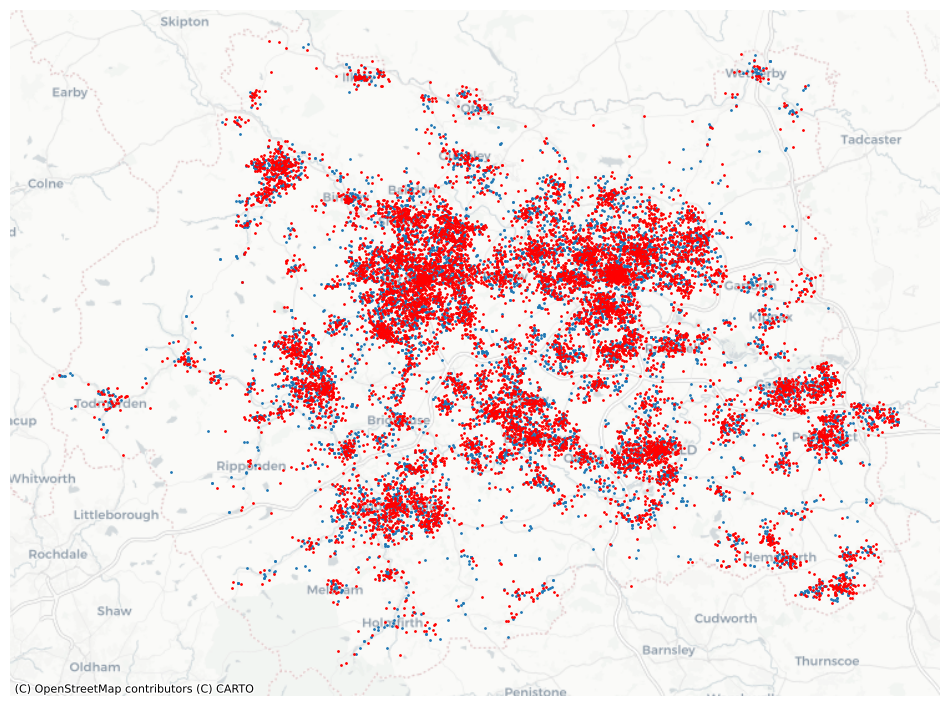

In [ ]:
# replicate above for blog
import contextily as cx

ax = crime_data.sample(n_crimes).to_crs(epsg=3857).plot(figsize=(12, 10), markersize=1)
synth_crime.to_crs(epsg=3857).plot(ax=ax, markersize=1, c="r")
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=10)